4-split multi-input (MICAE) model with tied weights

In [2]:
import sys; sys.path.insert(0, '..')
import models
import dataset
from keras.models import Model
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [3]:
from skimage.transform import resize
import tensorflow as tf

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = resize(x_train, (x_train.shape[0], 32, 32, 1))
x_test = resize(x_test, (x_test.shape[0], 32, 32, 1))

batch_size = 32
train_gen = dataset.BatchGenerator2(x_train, batch_size)
test_gen = dataset.BatchGenerator2(x_test, batch_size)

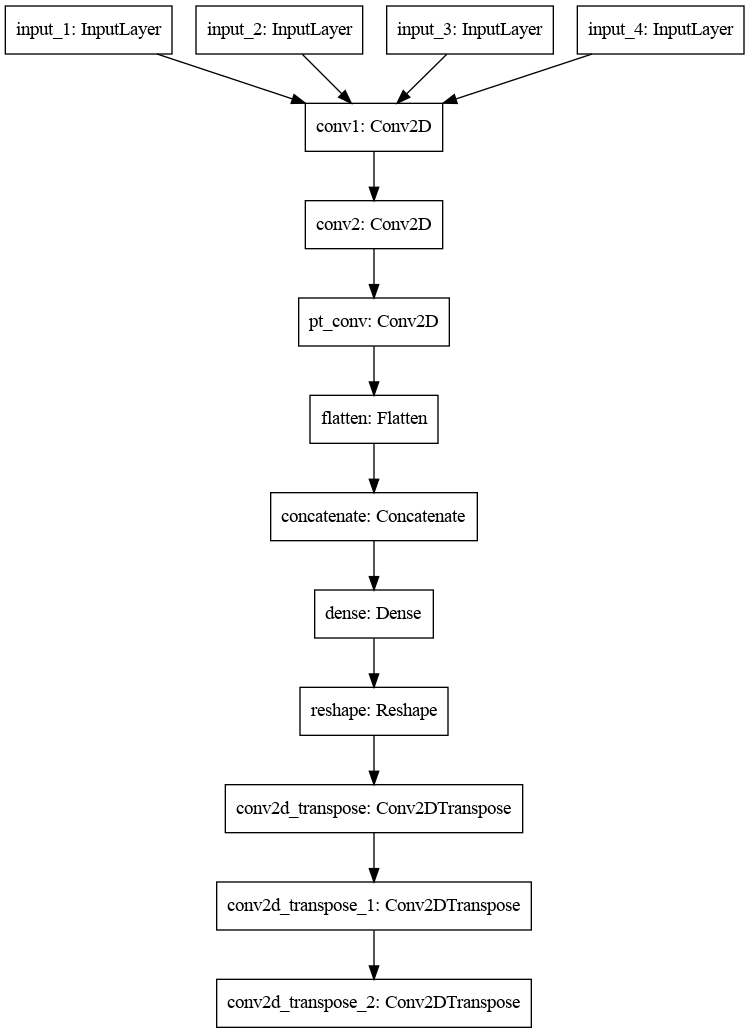

In [4]:
#input_shape = (14,14,1)
input_shape = (16,16,1)
latent_dim = 4

# shared layers
#conv1  = Conv2D(filters=32, kernel_size=(3,3), strides=(3,3), activation='relu', padding='valid', name='conv1')
conv1  = Conv2D(filters=32, kernel_size=(4,4), strides=(4,4), activation='relu', padding='valid', name='conv1')
conv2  = Conv2D(filters=64, kernel_size=(2,2), strides=(2,2), activation='relu', padding='valid', name='conv2')
pt_conv = Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), activation='sigmoid', padding='valid', name='pt_conv')
flat = Flatten()

inputs = [Input(shape=input_shape) for _ in range(4)]
outputs = []
for i in range(4):
    enc_out = flat(pt_conv(conv2(conv1(inputs[i]))))
    outputs.append(enc_out)
latent = concatenate(outputs, name="concatenate")

# decoder
# x = Dense(units=7*7*32, activation='relu', name='dense')(latent)
# x = Reshape(target_shape=(7, 7, 32), name='reshape')(x)
x = Dense(units=8*8*32, activation='relu', name='dense')(latent)
x = Reshape(target_shape=(8, 8, 32), name='reshape')(x)
x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same')(x)
dec_out = Conv2DTranspose(filters=1, kernel_size=3, padding='same')(x)

model = Model(inputs, dec_out,)
model.compile(loss='mse', optimizer='rmsprop')
# print(model.summary())
plot_model(model)

In [9]:
history = model.fit(train_gen, validation_data=test_gen, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0292 - val_loss: 0.0245
Epoch 2/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0187 - val_loss: 0.0165
Epoch 3/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0164 - val_loss: 0.0155
Epoch 4/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0151 - val_loss: 0.0139
Epoch 5/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0143 - val_loss: 0.0131
Epoch 6/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0137 - val_loss: 0.0139
Epoch 7/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0132 - val_loss: 0.0130
Epoch 8/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0129 - val_loss: 0.0127
Epoch 9/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 10/20
1875/1875 [==============================] - 12s 7ms/step - l

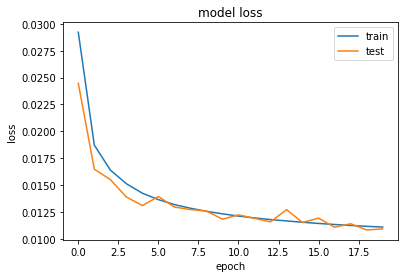

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('../img/07/07_micae_4split%d_tiedWeights_loss.svg'% latent_dim)
plt.show()

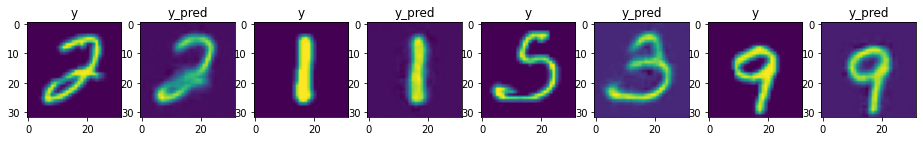

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))
a = 5
for (xs, ys), i in zip(test_gen, range(1,a)):
    ys_hat = model.predict(xs)
    odd, even = (2*i)-1, 2*i
    ax = plt.subplot(1, a*2, odd)
    ax.set_title('y')
    #plt.imshow(ys[i].reshape(28,28))
    plt.imshow(ys[i].reshape(32,32))
    ax = plt.subplot(1, a*2, even)
    ax.set_title('y_pred')
    #plt.imshow(ys_hat[i].reshape(28,28))
    plt.imshow(ys_hat[i].reshape(32,32))